# Dependance of attendance rate on offence rate
The offence rates are reported for Local Government Areas so many schools will have the same LGA offence rate.  

The offence rate is the sum of all the offences that have been reported in a year and is used as a relative  
indication of the crime rate  

The notebook reads in the offence rates and student attendance data and generates two figures:  
* A scatter plot of student attendance vs offence rates to get an overall view of any relationship, and   
* A set of histograms of student attendance rates for each quartile in the offence rate data      

Output:  
* ```../data/fig1-part4.png``` Scatter plot of attendance rate vs offences rate
* ```../data/fig2-part4.png``` Probability distribution of attendance rate conditioned on offences rate

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats 
import math 

In [2]:
#read in the LGA offence rate table and select the 5 years of the study
annual_sum_offence_rates_fn = '../data/annual_total_offence_rates.csv '
offence_rates_df = pd.read_csv(annual_sum_offence_rates_fn,index_col=0)
offence_rates_df = offence_rates_df.loc['2015':'2019',:  ]
offence_rates_df.head()

,Aurukun Shire Council,Balonne Shire Council,Banana Shire Council,Barcaldine Regional Council,Barcoo Shire Council,Blackall-Tambo Regional Council,Boulia Shire Council,Brisbane City Council,Bulloo Shire Council,Bundaberg Regional Council,...,Torres Shire Council,Torres Strait Island Regional Council,Townsville City Council,Weipa Town Council,Western Downs Regional Council,Whitsunday Regional Council,Winton Shire Council,Woorabinda Shire Council,Wujal Wujal Shire Council,Yarrabah Shire Council
2015,17636,5000,2332,3080,2413,3471,5475,3795,5467,4105,...,19653,18160,19873,19289,20317,20044,20352,41383,32628,23968
2016,17898,5271,2527,3833,3183,3877,5654,3942,5281,4372,...,19772,18386,20237,19380,20761,19922,20199,47816,34389,24169
2017,18639,7420,2466,2641,3639,4394,3658,3904,3811,4419,...,19552,18209,19970,19735,20574,20004,18940,36318,32172,23268
2018,18796,4664,2326,2207,3027,3492,5822,3986,4017,4585,...,19889,18529,19994,19647,20668,19978,19021,37686,30292,22843
2019,21332,4684,2842,2191,5865,2986,3076,4125,3802,4645,...,19226,18010,20298,19197,21342,20004,20093,37459,29136,22979


In [3]:
#read in the cleaned student attendance data
student_attendance_fn = '../data/cleaned_data_schoolattendancerate.csv'
student_attendance_df = pd.read_csv(student_attendance_fn)
student_attendance_df.head()

,School Code,School,Attendance Year,School Type,School Category,Remoteness Area,Region,Local Government Area,State Electorate,FTE Days Attended,Possible Attendance Days,Attendance Rate,Official Low Year Level,Official High Year Level,Suburb,Post Code,All Student Count,Longitude,Latitude
0,591,Abercorn State School,2015,State School,Primary,Outer Regional Australia,Central Queensland,North Burnett (R),Callide,1987.5,2103.0,94.5,Prep Year,Year 6,Abercorn,4627,18.0,151.127031,-25.135955
1,591,Abercorn State School,2016,State School,Primary,Outer Regional Australia,Central Queensland,North Burnett (R),Callide,1632.5,1705.0,95.7,Prep Year,Year 6,Abercorn,4627,18.0,151.127031,-25.135955
2,591,Abercorn State School,2017,State School,Primary,Outer Regional Australia,Central Queensland,North Burnett (R),Callide,1405.0,1440.0,97.6,Prep Year,Year 6,Abercorn,4627,18.0,151.127031,-25.135955
3,591,Abercorn State School,2018,State School,Primary,Outer Regional Australia,Central Queensland,North Burnett (R),Callide,1640.0,1700.0,96.5,Prep Year,Year 6,Abercorn,4627,18.0,151.127031,-25.135955
4,591,Abercorn State School,2019,State School,Primary,Outer Regional Australia,Central Queensland,North Burnett (R),Callide,1657.5,1728.0,95.9,Prep Year,Year 6,Abercorn,4627,18.0,151.127031,-25.135955


In [4]:
# trim the student attendance data and add the offence rate column 
attendance_offences_df = student_attendance_df.drop(['School Type','State Electorate','FTE Days Attended','Possible Attendance Days','All Student Count','Suburb'],axis=1)
attendance_offences_df['Offence Rate'] = [math.nan for i in range(len(attendance_offences_df))]

In [5]:
#need to reformat the LGA names in student_attendance to match the LGA names used in the offence rate data
name_dict = {'(C)':'City Council', '(R)':'Regional Council', '(S)':'Shire Council' }
student_lga = student_attendance_df['Local Government Area'].unique()
offences_lga = offence_rates_df.columns
years = attendance_offences_df['Attendance Year'].unique()

#loop over the rows to fill in the offence data 
for irow in range(len(attendance_offences_df)):
    lga = attendance_offences_df.iloc[irow,6]
    year = attendance_offences_df.iloc[irow,2]
    
    #get the corresponding offences name for the LGA
    for dname in name_dict:
        offset =  lga.find(dname)
        if offset > 0:
            name = lga[0:offset] + name_dict[dname] 
            
    #get the offence rate if the name is found else print an info message        
    try:
        offence_rate = offence_rates_df.loc[year,:][name]
        attendance_offences_df.iloc[irow,13] = offence_rate
    except KeyError:
        print("Offence rate for {} not found".format(name))
        continue

#drop any rows that do not have offence rate data         
attendance_offences_df = attendance_offences_df.dropna(how='any')

Offence rate for Blackall Tambo Regional Council not found
Offence rate for Blackall Tambo Regional Council not found
Offence rate for Blackall Tambo Regional Council not found
Offence rate for Blackall Tambo Regional Council not found
Offence rate for Blackall Tambo Regional Council not found
Offence rate for Blackall Tambo Regional Council not found
Offence rate for Blackall Tambo Regional Council not found
Offence rate for Blackall Tambo Regional Council not found
Offence rate for Blackall Tambo Regional Council not found
Offence rate for Blackall Tambo Regional Council not found


## Scatter plot of attendance rate at a school and the LGA reported crime rate

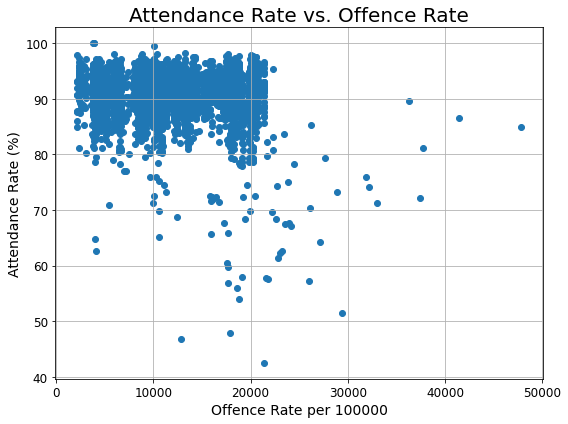

In [6]:
fig, ax = plt.subplots(figsize=(8,6))
y = attendance_offences_df['Attendance Rate']
x = attendance_offences_df['Offence Rate']
ax.scatter(x,y)

ax.set_title('Attendance Rate vs. Offence Rate',fontsize=20)
ax.set_xlabel('Offence Rate per 100000',fontsize=14)
ax.set_ylabel('Attendance Rate (%)',fontsize=14)
ax.tick_params(axis='x',labelsize=12)
ax.tick_params(axis='y',labelsize=12)
ax.grid(True)
fig.tight_layout()
plt.savefig('../data/fig1-part4.png')
plt.show()

## Probability distribution of attendance rate conditioned on offence rate

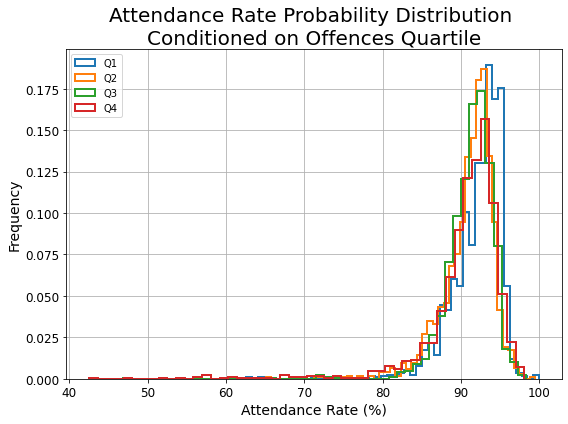

In [7]:
# make quartile for the offences data
attendance_offences_df['Offence Rate Quartile'] = pd.qcut(attendance_offences_df['Offence Rate'],4,labels=False)
label = ["Q1", "Q2", "Q3", "Q4"]

fig, ax = plt.subplots(figsize=(8,6))
for ia in range(4):
    x = attendance_offences_df.loc[attendance_offences_df['Offence Rate Quartile']==ia]['Attendance Rate']
    ax.hist(x,bins=50,histtype='step',lw=2,label=label[ia],density=True)

ax.set_title('Attendance Rate Probability Distribution \nConditioned on Offences Quartile',fontsize=20)
ax.set_xlabel('Attendance Rate (%)',fontsize=14)
ax.set_ylabel('Frequency',fontsize=14)
ax.tick_params(axis='x',labelsize=12)
ax.tick_params(axis='y',labelsize=12)
ax.legend(loc='upper left')
ax.grid(True)
fig.tight_layout()
plt.savefig('../data/fig2-part4.png')
plt.show()

## Test if the conditional probability distributions for Q1 is identical to the others  
Use the Kolmogorov-Smirnov 2-tailed test  
I conclude from the low p-values that the hyothesis that the probability distributions for Q1 is identical  
to the distributions of the other 3 quartiles can be rejected at the 0.05 level of significance

In [8]:
# test if there is a significant difference between the first and second quartiles using the Kolmogorov-Smirnov test
x = attendance_offences_df.loc[attendance_offences_df['Offence Rate Quartile']==0]['Attendance Rate']
for iq in range(1,4):
    y = attendance_offences_df.loc[attendance_offences_df['Offence Rate Quartile']==iq]['Attendance Rate']
    result = stats.ks_2samp(x, y)
    print ("Q1 vs Q{}: KS Statistic = {:.3f}, pvalue = {:.3e} ".format(iq+1, result[0], result[1]))

Q1 vs Q2: KS Statistic = 0.237, pvalue = 2.512e-38 
Q1 vs Q3: KS Statistic = 0.230, pvalue = 2.436e-36 
Q1 vs Q4: KS Statistic = 0.190, pvalue = 6.082e-25 


In [9]:
# print out the summary statistics for each quartile 
index = ["number", "min", "max", 'mean', 'variance', "skewness", 'kurtosis']
results_df = pd.DataFrame(index=index)

for iq in range(4):
    y = attendance_offences_df.loc[attendance_offences_df['Offence Rate Quartile']==iq]['Attendance Rate'] 
    r = stats.describe(y)
    x = [r.nobs, r.minmax[0], r.minmax[1], r.mean, r.variance, r.skewness, r.kurtosis]
    results_df[label[iq]] = x
    
results_df.style.format("{:.2f}")    

,Q1,Q2,Q3,Q4
number,1554.00,1501.00,1519.00,1525.00
min,62.60,65.10,46.80,42.50
max,100.00,99.50,98.30,98.10
mean,92.20,91.04,91.22,90.54
variance,9.89,10.85,10.28,28.91
skewness,-2.04,-1.74,-3.47,-3.65
kurtosis,10.59,6.48,32.29,19.53


## Conditional descriptive statistics for attendance rate
The descriptive statistics were calculated for each quartile range of the offence rate
* Q1,Q2,Q3 are similar (but still statistically different), Q4 is quite different from the rest    
* The variance for Q4 is roughly 30, which is significantly larger than the variance for the other three quartiles
* All the distributions have negative skewness (are skewed to the left), which is understandable as the mean is near the maximum value of 100  
* The probability distributions have a high Kurtosis since the left tail of the distribution is heavy relative to a Normal distribution  
* The distribution of student attendance rates is not Normal due to the relatively large number of schools with low attendance rates  
and the skewness to the left